# Recuperation des données

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',
    'META', 'NVDA', 'JPM', 'JNJ', 'V',
    'AIR.PA', 'MC.PA', 'TTE.PA', 'SAN.PA', 'ASML.AS',
    'SIE.DE', 'HSBA.L', 'NESN.SW', 'BMW.DE', 'IBE.MC'
]

# Augmenter la période à 5 ans au lieu de 18 mois pour avoir plus de données
data = yf.download(tickers, start="2010-01-01", end="2025-01-01")

print("Colonnes disponibles:")
print(data.columns.levels[0])

C:\Users\lips\AppData\Local\Temp\ipykernel_17604\4229310622.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  20 of 20 completed


Colonnes disponibles:
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [ ]:
# Fonction pour calculer les indicateurs pour chaque ticker
def add_technical_indicators(df, ticker):
    """
    Ajoute les indicateurs techniques à un DataFrame pour un ticker donné
    """
    # Extraction des données de clôture pour le ticker
    close = df['Close'][ticker].dropna()
    high = df['High'][ticker].dropna()
    low = df['Low'][ticker].dropna()
    volume = df['Volume'][ticker].dropna()

    common_index = close.index.intersection(high.index).intersection(low.index).intersection(volume.index)

    close = close.loc[common_index]
    high = high.loc[common_index]
    low = low.loc[common_index]
    volume = volume.loc[common_index]
    # DataFrame pour stocker les indicateurs
    indicators = pd.DataFrame(index=close.index)

    # Prix de clôture
    indicators['Close'] = close

    # RSI (Relative Strength Index) - 14 jours par défaut
    rsi = RSIIndicator(close=close, window=14)
    indicators['RSI'] = rsi.rsi()

    # MACD (Moving Average Convergence Divergence)
    macd = MACD(close=close, window_slow=26, window_fast=12, window_sign=9)
    indicators['MACD'] = macd.macd()
    indicators['MACD_Signal'] = macd.macd_signal()
    indicators['MACD_Diff'] = macd.macd_diff()

    # Moving Averages
    indicators['SMA_20'] = SMAIndicator(close=close, window=20).sma_indicator()
    indicators['SMA_50'] = SMAIndicator(close=close, window=50).sma_indicator()
    indicators['EMA_12'] = EMAIndicator(close=close, window=12).ema_indicator()
    indicators['EMA_26'] = EMAIndicator(close=close, window=26).ema_indicator()

    # Bollinger Bands
    bollinger = BollingerBands(close=close, window=20, window_dev=2)
    indicators['BB_High'] = bollinger.bollinger_hband()
    indicators['BB_Low'] = bollinger.bollinger_lband()
    indicators['BB_Mid'] = bollinger.bollinger_mavg()

    # Indicateurs dérivés utiles pour LSTM
    indicators['Price_Change'] = close.pct_change(fill_method=None) # fill_method=None permet d'éviter les erreurs de warning
    indicators['Volume_Change'] = volume.pct_change(fill_method=None)

    # Distance du prix par rapport aux moyennes mobiles (normalisée) -- éviter division par zéro
    eps = 1e-8
    indicators['Distance_SMA20'] = (close - indicators['SMA_20']) / (indicators['SMA_20'] + eps)
    indicators['Distance_SMA50'] = (close - indicators['SMA_50']) / (indicators['SMA_50'] + eps)

    return indicators


In [ ]:
# Calcul des indicateurs pour chaque ticker
all_indicators = {}
for ticker in tickers:
    print(f"Calcul des indicateurs pour {ticker}...")
    indicators = add_technical_indicators(data, ticker)
    all_indicators[ticker] = indicators

    # Afficher un aperçu
    print(f"\n{ticker} - Dernières valeurs:")
    print(indicators.tail())
    print("\n" + "="*50 + "\n")

# Exemple: accéder aux indicateurs d'AAPL
aapl_indicators = all_indicators['AAPL']
print("Indicateurs disponibles pour AAPL:")
print(aapl_indicators.columns.tolist())

Calcul des indicateurs pour AAPL...

AAPL - Dernières valeurs:
                 Close        RSI      MACD  MACD_Signal  MACD_Diff  \
Date                                                                  
2024-12-24  257.037506  75.750231  6.046650     5.371807   0.674843   
2024-12-26  257.853790  76.452831  6.278551     5.553156   0.725395   
2024-12-27  254.439240  67.626243  6.116303     5.665785   0.450518   
2024-12-30  251.064514  60.225592  5.650276     5.662683  -0.012407   
2024-12-31  249.292511  56.715891  5.079408     5.546028  -0.466620   

                SMA_20      SMA_50      EMA_12      EMA_26     BB_High  \
Date                                                                     
2024-12-24  245.184590  234.761248  249.332002  243.285352  257.892373   
2024-12-26  246.377197  235.267498  250.643046  244.364495  259.139980   
2024-12-27  247.405546  235.746626  251.227076  245.110773  259.253889   
2024-12-30  248.145699  236.150901  251.202066  245.551790  258.91748

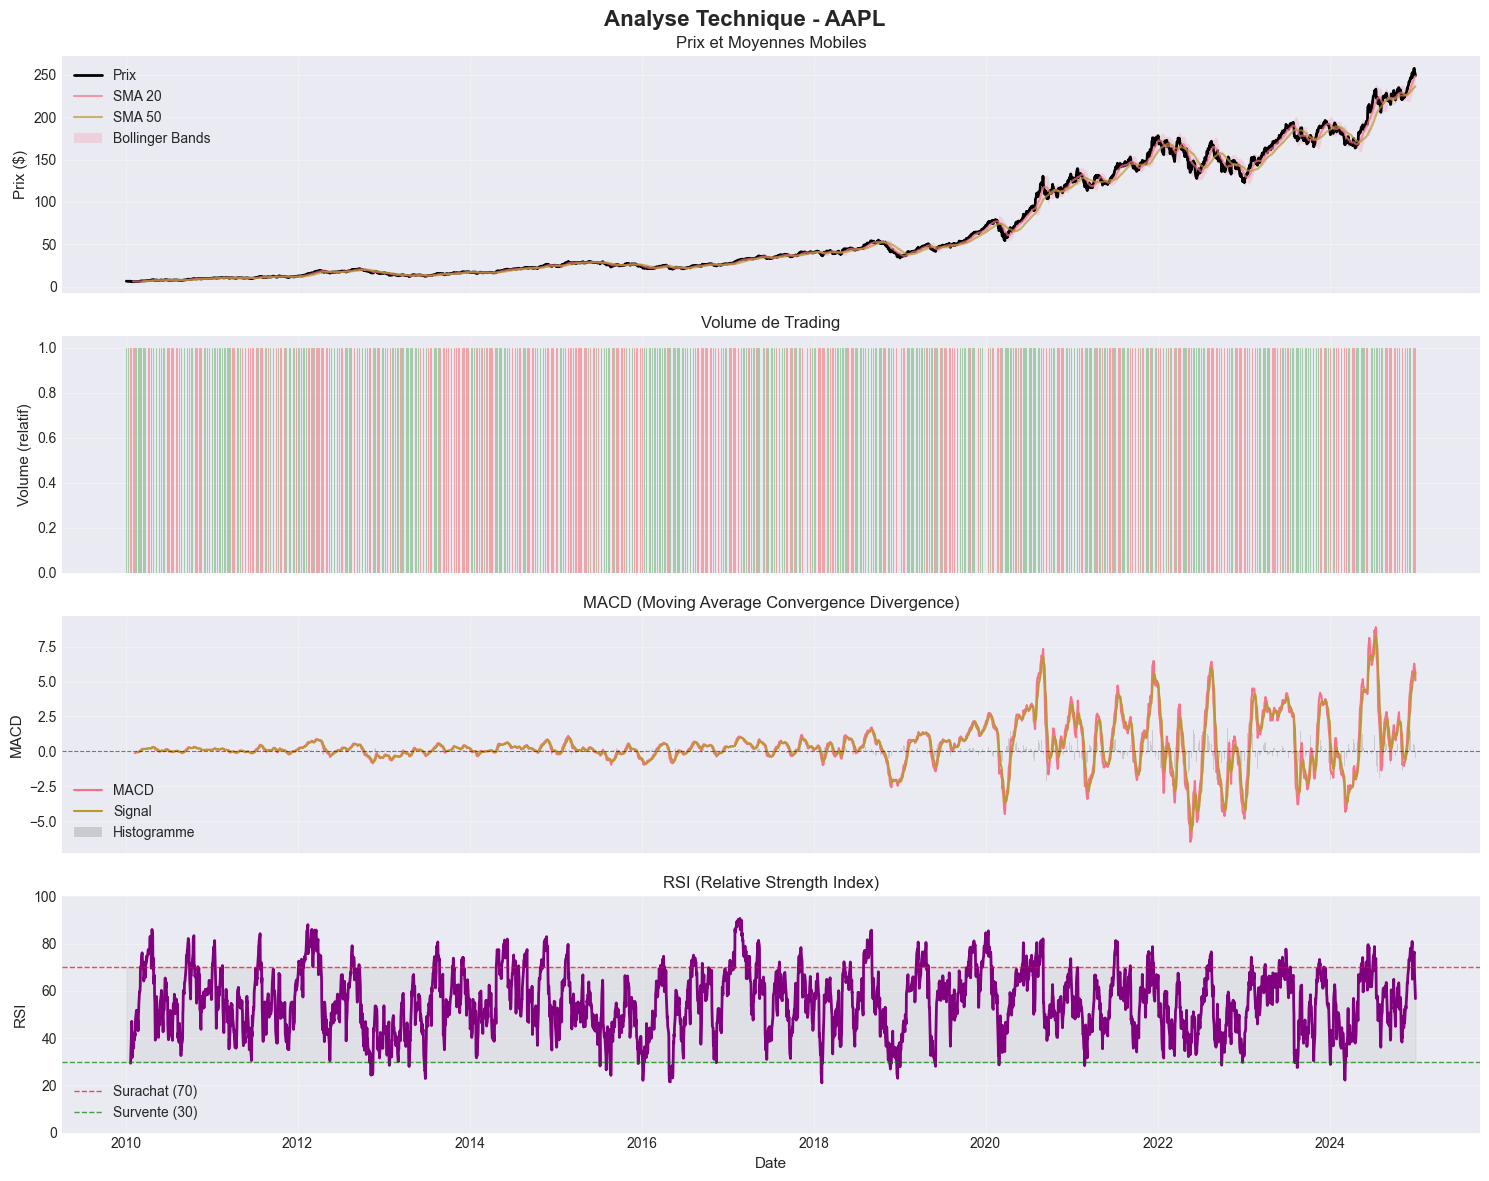

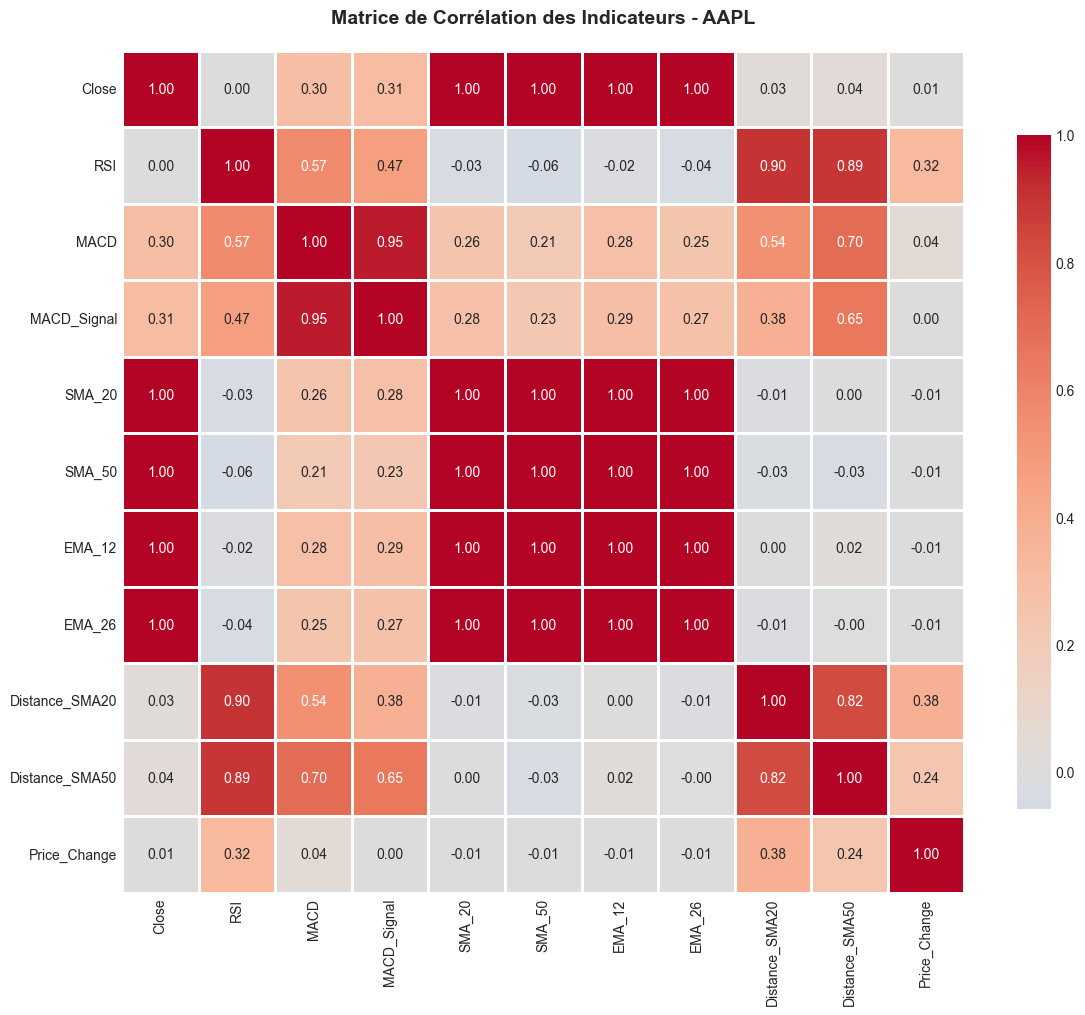

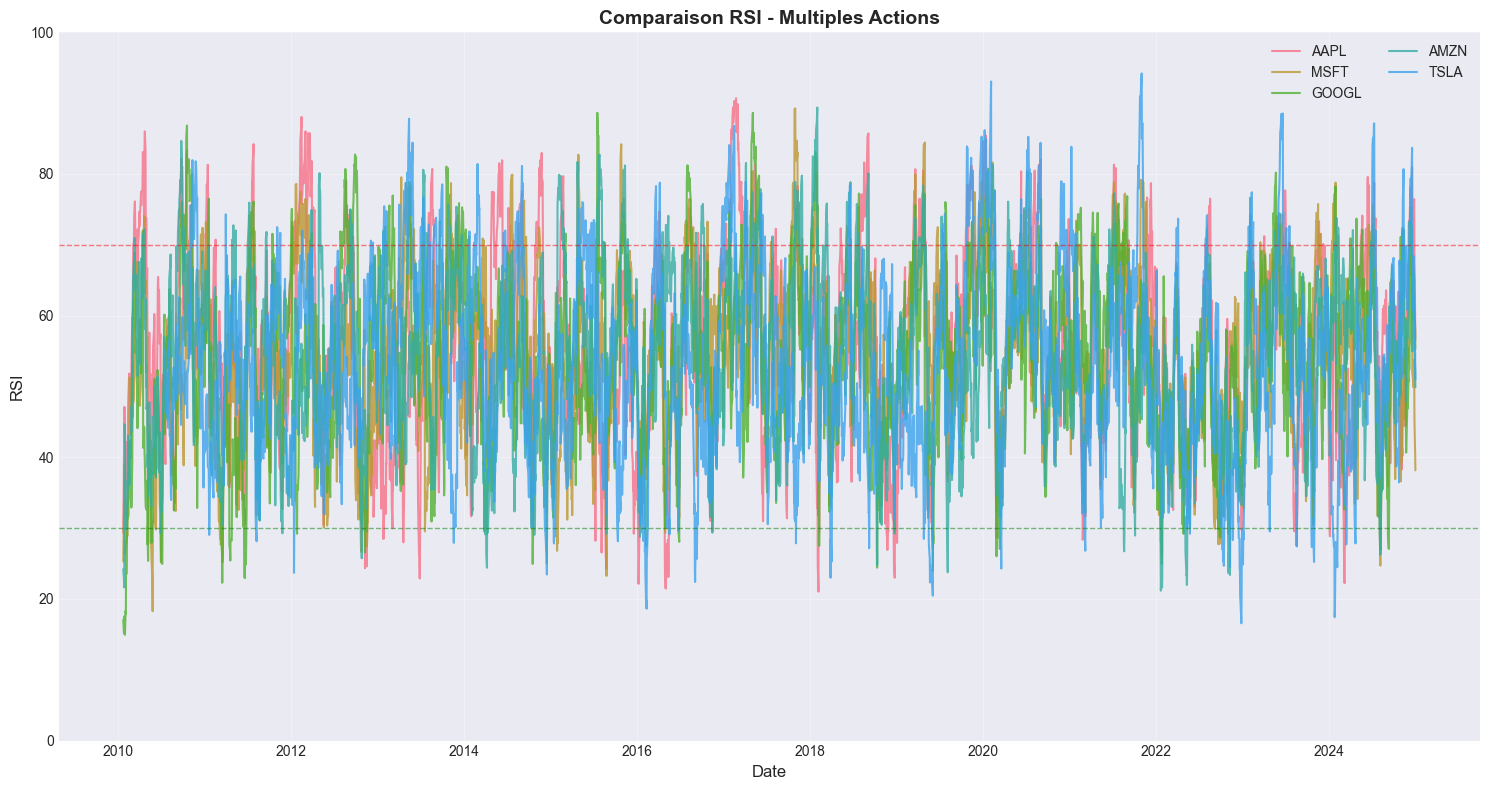

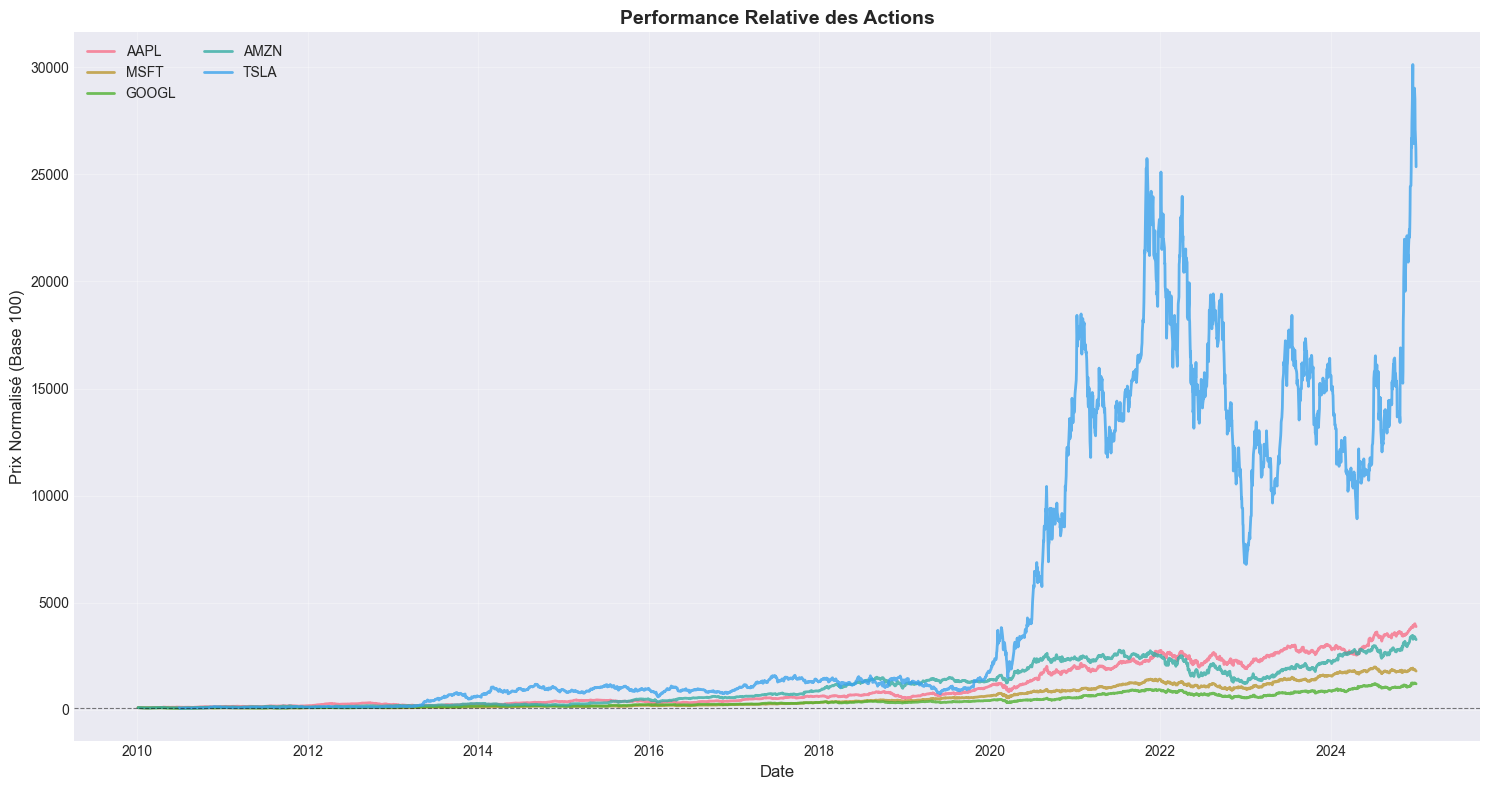

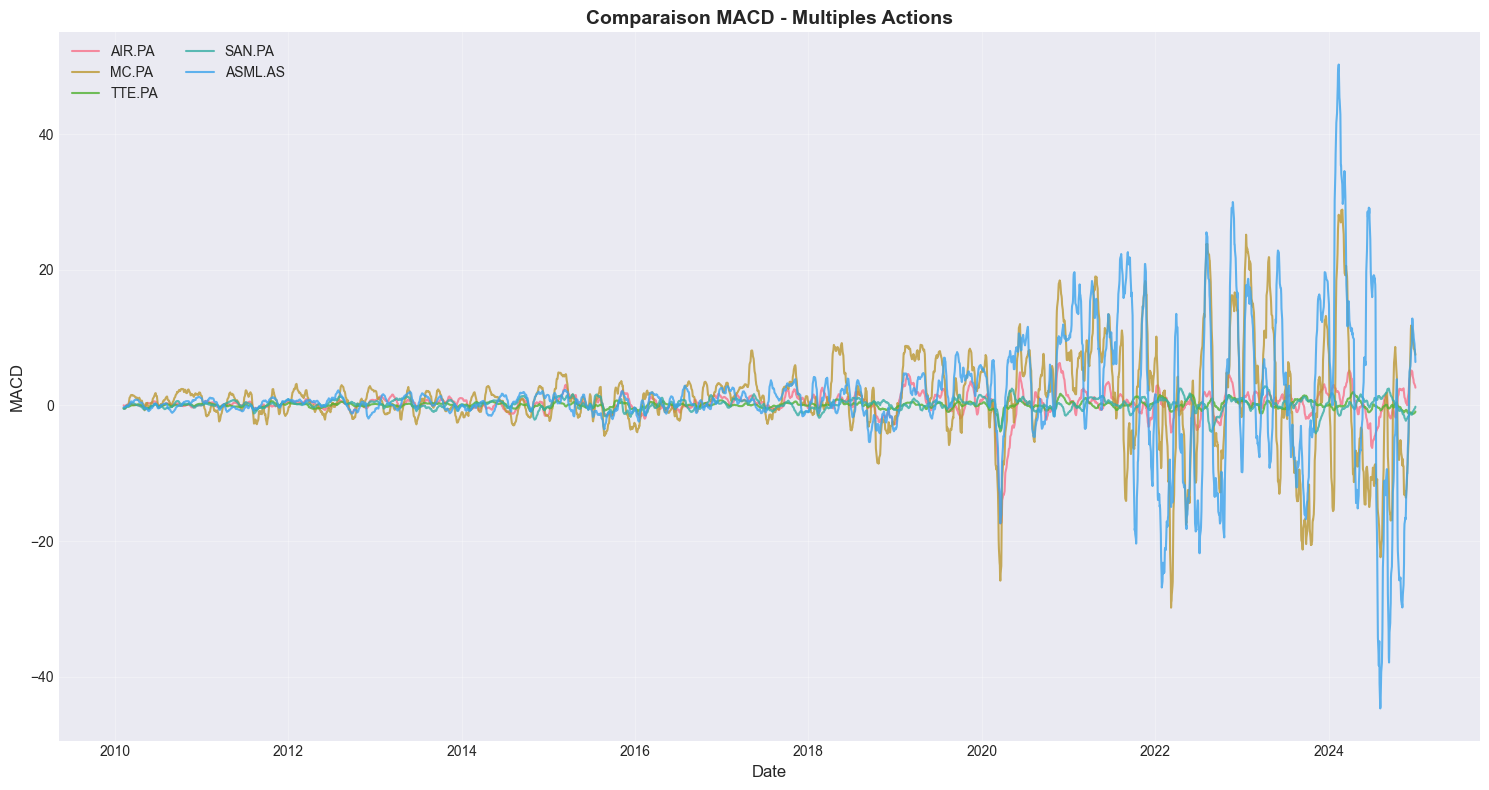

In [ ]:
# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def plot_stock_with_indicators(indicators, ticker, figsize=(15, 12)):
    """
    Crée une visualisation complète avec prix et tous les indicateurs techniques
    """
    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
    fig.suptitle(f'Analyse Technique - {ticker}', fontsize=16, fontweight='bold')

    # 1. Prix et Moving Averages
    ax1 = axes[0]
    ax1.plot(indicators.index, indicators['Close'], label='Prix', linewidth=2, color='black')
    ax1.plot(indicators.index, indicators['SMA_20'], label='SMA 20', linewidth=1.5, alpha=0.7)
    ax1.plot(indicators.index, indicators['SMA_50'], label='SMA 50', linewidth=1.5, alpha=0.7)
    ax1.fill_between(indicators.index, indicators['BB_Low'], indicators['BB_High'],
                      alpha=0.2, label='Bollinger Bands')
    ax1.set_ylabel('Prix ($)', fontsize=11)
    ax1.set_title('Prix et Moyennes Mobiles', fontsize=12)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # 2. Volume
    ax2 = axes[1]
    colors = ['green' if indicators['Price_Change'].iloc[i] >= 0 else 'red'
              for i in range(len(indicators))]
    ax2.bar(indicators.index, indicators.index.map(lambda x: 1), color=colors, alpha=0.3, width=0.8)
    ax2.set_ylabel('Volume (relatif)', fontsize=11)
    ax2.set_title('Volume de Trading', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # 3. MACD
    ax3 = axes[2]
    ax3.plot(indicators.index, indicators['MACD'], label='MACD', linewidth=1.5)
    ax3.plot(indicators.index, indicators['MACD_Signal'], label='Signal', linewidth=1.5)
    ax3.bar(indicators.index, indicators['MACD_Diff'], label='Histogramme',
            alpha=0.3, color='gray')
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax3.set_ylabel('MACD', fontsize=11)
    ax3.set_title('MACD (Moving Average Convergence Divergence)', fontsize=12)
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)

    # 4. RSI
    ax4 = axes[3]
    ax4.plot(indicators.index, indicators['RSI'], linewidth=2, color='purple')
    ax4.axhline(y=70, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Surachat (70)')
    ax4.axhline(y=30, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Survente (30)')
    ax4.fill_between(indicators.index, 30, 70, alpha=0.1, color='gray')
    ax4.set_ylabel('RSI', fontsize=11)
    ax4.set_xlabel('Date', fontsize=11)
    ax4.set_title('RSI (Relative Strength Index)', fontsize=12)
    ax4.set_ylim(0, 100)
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def plot_correlation_matrix(indicators, ticker, figsize=(12, 10)):
    """
    Matrice de corrélation entre les indicateurs
    """
    # Sélection des colonnes numériques pertinentes
    cols_to_correlate = ['Close', 'RSI', 'MACD', 'MACD_Signal',
                         'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26',
                         'Distance_SMA20', 'Distance_SMA50', 'Price_Change']

    # Filtrer les colonnes qui existent
    existing_cols = [col for col in cols_to_correlate if col in indicators.columns]

    corr_data = indicators[existing_cols].corr()

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                ax=ax)
    ax.set_title(f'Matrice de Corrélation des Indicateurs - {ticker}',
                 fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

def plot_multiple_tickers_comparison(all_indicators, tickers_to_plot, metric='RSI', figsize=(15, 8)):
    """
    Compare un indicateur spécifique pour plusieurs tickers
    """
    fig, ax = plt.subplots(figsize=figsize)

    for ticker in tickers_to_plot:
        if ticker in all_indicators:
            indicators = all_indicators[ticker]
            ax.plot(indicators.index, indicators[metric],
                   label=ticker, linewidth=1.5, alpha=0.8)

    if metric == 'RSI':
        ax.axhline(y=70, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=30, color='green', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_ylim(0, 100)

    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'Comparaison {metric} - Multiples Actions', fontsize=14, fontweight='bold')
    ax.legend(loc='best', ncol=2)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

def plot_price_normalized_comparison(all_indicators, tickers_to_plot, figsize=(15, 8)):
    """
    Compare l'évolution normalisée des prix (base 100)
    """
    fig, ax = plt.subplots(figsize=figsize)

    for ticker in tickers_to_plot:
        if ticker in all_indicators:
            indicators = all_indicators[ticker]
            # Normalisation à 100 au départ
            normalized_price = (indicators['Close'] / indicators['Close'].iloc[0]) * 100
            ax.plot(indicators.index, normalized_price,
                   label=ticker, linewidth=2, alpha=0.8)

    ax.axhline(y=100, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Prix Normalisé (Base 100)', fontsize=12)
    ax.set_title('Performance Relative des Actions', fontsize=14, fontweight='bold')
    ax.legend(loc='best', ncol=2)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

# Exemple d'utilisation avec vos données
# Remplacez 'all_indicators' par votre dictionnaire d'indicateurs

# Pour un ticker spécifique
ticker_example = 'AAPL'
if ticker_example in all_indicators:
    fig1 = plot_stock_with_indicators(all_indicators[ticker_example], ticker_example)
    plt.show()

    fig2 = plot_correlation_matrix(all_indicators[ticker_example], ticker_example)
    plt.show()

# Comparaison de plusieurs tickers
tickers_us = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
fig3 = plot_multiple_tickers_comparison(all_indicators, tickers_us, metric='RSI')
plt.show()

fig4 = plot_price_normalized_comparison(all_indicators, tickers_us)
plt.show()

# Comparaison des actions européennes
tickers_eu = ['AIR.PA', 'MC.PA', 'TTE.PA', 'SAN.PA', 'ASML.AS']
fig5 = plot_multiple_tickers_comparison(all_indicators, tickers_eu, metric='MACD')
plt.show()


In [ ]:
# Nettoyage des données manquantes

import pandas as pd
import numpy as np

def clean_indicators(indicators_dict):
    cleaned_indicators = {}

    for ticker, df in indicators_dict.items():
        # Supprimer les lignes avec NaN
        # Les premiers jours ont des NaN à cause des indicateurs (ex: SMA_50 a besoin de 50 jours)
        df_clean = df.dropna()
        cleaned_indicators[ticker] = df_clean

    return cleaned_indicators

# Nettoyer toutes les données
cleaned_data = clean_indicators(all_indicators)
print(cleaned_data)

{'AAPL':                  Close        RSI      MACD  MACD_Signal  MACD_Diff  \
Date                                                                  
2010-03-16    6.731489  70.350645  0.183521     0.131892   0.051629   
2010-03-17    6.721592  69.559445  0.182167     0.141947   0.040220   
2010-03-18    6.737486  70.140236  0.180299     0.149618   0.030681   
2010-03-19    6.665509  64.169462  0.171038     0.153902   0.017136   
2010-03-22    6.740487  67.292873  0.167815     0.156684   0.011130   
...                ...        ...       ...          ...        ...   
2024-12-24  257.037506  75.750231  6.046650     5.371807   0.674843   
2024-12-26  257.853790  76.452831  6.278551     5.553156   0.725395   
2024-12-27  254.439240  67.626243  6.116303     5.665785   0.450518   
2024-12-30  251.064514  60.225592  5.650276     5.662683  -0.012407   
2024-12-31  249.292511  56.715891  5.079408     5.546028  -0.466620   

                SMA_20      SMA_50      EMA_12      EMA_26     BB_H

## Creation des labels pour la prediction sur multi-horizons

In [ ]:
def create_multi_horizon_labels(df, horizons=[1, 5, 30]):
    df_labeled = df.copy()

    # Créer les colonnes target pour chaque horizon
    for h in horizons:
        # Prix futur (valeur brute)
        df_labeled[f'Target_Price_{h}d'] = df_labeled['Close'].shift(-h)

        # Variation en pourcentage
        df_labeled[f'Target_Return_{h}d'] = (
            (df_labeled['Close'].shift(-h) - df_labeled['Close']) / df_labeled['Close'] * 100
        )

    # Ne garder que les lignes qui ont au moins un horizon valide
    target_cols = [f'Target_Return_{h}d' for h in horizons]
    df_labeled = df_labeled.dropna(subset=target_cols, how='all')

    # Afficher des statistiques
    print(f"  Statistiques des targets:")
    for col in target_cols:
        n_valid = df_labeled[col].notna().sum()
        print(f"    {col}: {n_valid} valeurs valides")

    return df_labeled

## Appliquer à tous les tickers

In [ ]:
labeled_data = {}
normalized_data = {}
scalers = {} # Les scalers seront créés plus tard

for ticker, df in cleaned_data.items():
    print(f"\n{ticker}:")
    print(f"  Taille initiale: {len(df)}")

    # 1. Créer les labels
    df_labeled = create_multi_horizon_labels(df, horizons=[1, 5, 30])
    print(f"  Après labeling: {len(df_labeled)}")
    labeled_data[ticker] = df_labeled

    # On stocke  les données SANS normalisation.
    # La normalisation se fera plus tard, après le split des séquences.
    normalized_data[ticker] = df_labeled
    print(f"  Prêt pour séquençage (non-normalisé): {len(df_labeled)}")


AAPL:
  Taille initiale: 3725
  Statistiques des targets:
    Target_Return_1d: 3724 valeurs valides
    Target_Return_5d: 3720 valeurs valides
    Target_Return_30d: 3695 valeurs valides
  Après labeling: 3724
  Prêt pour séquençage (non-normalisé): 3724

MSFT:
  Taille initiale: 3725
  Statistiques des targets:
    Target_Return_1d: 3724 valeurs valides
    Target_Return_5d: 3720 valeurs valides
    Target_Return_30d: 3695 valeurs valides
  Après labeling: 3724
  Prêt pour séquençage (non-normalisé): 3724

GOOGL:
  Taille initiale: 3725
  Statistiques des targets:
    Target_Return_1d: 3724 valeurs valides
    Target_Return_5d: 3720 valeurs valides
    Target_Return_30d: 3695 valeurs valides
  Après labeling: 3724
  Prêt pour séquençage (non-normalisé): 3724

AMZN:
  Taille initiale: 3725
  Statistiques des targets:
    Target_Return_1d: 3724 valeurs valides
    Target_Return_5d: 3720 valeurs valides
    Target_Return_30d: 3695 valeurs valides
  Après labeling: 3724
  Prêt pour séqu

## Création de sequences

In [ ]:
def create_sequences(df, window_size=60, horizons=[1, 5, 30]):
    """
    Crée des séquences temporelles pour le LSTM
    Version plus flexible :
    - Adapte window_size si pas assez de données
    - Gère les NaN dans les targets
    - Validation plus souple des séquences
    """
    print(f"  Shape initial du DataFrame: {df.shape}")

    # Colonnes cibles
    target_cols = [f'Target_Return_{h}d' for h in horizons]
    target_cols = [col for col in target_cols if col in df.columns]

    if not target_cols:
        raise ValueError("Aucune colonne target trouvée dans le DataFrame")

    # Features (toutes les colonnes sauf les targets)
    feature_cols = [col for col in df.columns if col not in target_cols]
    print(f"  Nombre de features: {len(feature_cols)}")
    print(f"  Nombre de targets: {len(target_cols)}")

    if not feature_cols:
        raise ValueError("Aucune colonne feature trouvée dans le DataFrame")

    # Adapter window_size si nécessaire
    n_samples = len(df)
    min_window = 5  # taille minimum de fenêtre
    if n_samples < window_size:
        original_window = window_size
        # Utiliser 20% des données comme taille de fenêtre, minimum 5
        window_size = max(min_window, min(window_size, n_samples // 5))
        print(f"  Attention: window_size réduit de {original_window} à {window_size} (adaptation aux données disponibles)")

    # Préparation des données
    features = df[feature_cols].values
    targets = df[target_cols].values

    # Création des séquences
    n_sequences = len(df) - window_size
    print(f"  Nombre potentiel de séquences: {n_sequences}")

    if n_sequences <= 0:
        print("  Pas assez de données pour créer des séquences")
        return np.array([]), np.array([]), feature_cols, target_cols

    X = []
    y = []

    for i in range(n_sequences):
        seq_features = features[i:i+window_size]
        seq_target = targets[i+window_size-1]  # target de la dernière timestep

        # Une séquence est valide si elle a moins de 20% de NaN
        if (np.isnan(seq_features).sum() / seq_features.size < 0.2 and
            not np.isnan(seq_target).any()):
            X.append(seq_features)
            y.append(seq_target)

    if len(X) > 0:
        X = np.array(X)
        y = np.array(y)
        print(f"  Séquences finales:")
        print(f"    X shape: {X.shape}, y shape: {y.shape}")
        print(f"    Window size utilisé: {window_size}")
    else:
        X = np.array([])
        y = np.array([])
        print("  Aucune séquence valide créée")

    return X, y, feature_cols, target_cols

## Fonction de split/train/test

In [ ]:
def prepare_train_test_split(X, y, test_size=0.2, val_size=0.1):
    n_samples = len(X)
    test_idx = int(n_samples * (1 - test_size))
    val_idx = int(test_idx * (1 - val_size))

    X_train, y_train = X[:val_idx], y[:val_idx]
    X_val, y_val = X[val_idx:test_idx], y[val_idx:test_idx]
    X_test, y_test = X[test_idx:], y[test_idx:]

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [1]:
def normalize_sequences_split(X_train, X_val, X_test, method='minmax'):
    """
    Normalise les séquences séparées (Train, Val, Test) en utilisant
    UNIQUEMENT le X_train pour le fit (ÉVITE LE DATA LEAKAGE).

    Args:
        X_train, X_val, X_test: Séquences 3D (samples, timesteps, features)
        method: 'minmax' ou 'standard'
    """

    if method == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    n_samples, n_timesteps, n_features = X_train.shape

    # 1. FIT UNIQUEMENT sur X_train
    # Reshape en 2D pour fitter (samples * timesteps, features)
    X_train_2d = X_train.reshape(-1, n_features)
    scaler.fit(X_train_2d)

    # 2. TRANSFORM sur tous les sets (et reshape en 3D)
    X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

In [33]:
# Réduire la taille de fenêtre par défaut et le nombre minimum de séquences
window_size = 30  # réduit de 60 à 30 jours
horizons = [1, 5, 30]  # garder les mêmes horizons de prédiction

In [ ]:
sequences_data = {}

print("Création des séquences...")

min_sequences = 10  # réduit de 30 à 10 pour être encore plus permissif

for ticker, df in normalized_data.items():
    print(f"\n{ticker}")

    try:
        # 1. Création des séquences (sur données NON-NORMALISÉES)
        X, y, feature_cols, target_cols = create_sequences(df, window_size, horizons)

        if len(X) < min_sequences:
            print(f" Ignoré ({len(X)} séquences, minimum requis: {min_sequences})")
            continue

        # 2. Split (Séparation) des données
        X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_test_split(X, y)

        # 3. Normalisation après le Split (Étape CRUCIALE contre le Data Leakage)
        # On utilise la fonction `normalize_sequences_split` ajoutée précédemment
        X_train_scaled, X_val_scaled, X_test_scaled, scaler_final = normalize_sequences_split(
            X_train, X_val, X_test, method='minmax'
        )
        print(f"  Normalisation effectuée (Scaler: {type(scaler_final).__name__})")

        # 4. Stockage des données NORMALISÉES et du scaler
        sequences_data[ticker] = {
            # On stocke les données normalisées
            'X_train': X_train_scaled, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
            # Les targets (y) n'ont pas besoin d'être normalisées
            'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
            'feature_cols': feature_cols, 'target_cols': target_cols,
            'window_size': window_size,
            'scaler': scaler_final # Le scaler (fit sur X_train) est stocké ici
        }

        print(f" Prêt !")

    except Exception as e:
        print(f" Erreur: {e}")
        continue

print(f"\nTerminé - {len(sequences_data)} tickers prêts")

Création des séquences...

AAPL
  Shape initial du DataFrame: (3724, 22)
  Nombre de features: 19
  Nombre de targets: 3
  Nombre potentiel de séquences: 3694
  Séquences finales:
    X shape: (3666, 30, 19), y shape: (3666, 3)
    Window size utilisé: 30
Train: 2638, Val: 294, Test: 734
  Normalisation effectuée (Scaler: MinMaxScaler)
 Prêt !

MSFT
  Shape initial du DataFrame: (3724, 22)
  Nombre de features: 19
  Nombre de targets: 3
  Nombre potentiel de séquences: 3694
  Séquences finales:
    X shape: (3666, 30, 19), y shape: (3666, 3)
    Window size utilisé: 30
Train: 2638, Val: 294, Test: 734
  Normalisation effectuée (Scaler: MinMaxScaler)
 Prêt !

GOOGL
  Shape initial du DataFrame: (3724, 22)
  Nombre de features: 19
  Nombre de targets: 3
  Nombre potentiel de séquences: 3694
  Séquences finales:
    X shape: (3666, 30, 19), y shape: (3666, 3)
    Window size utilisé: 30
Train: 2638, Val: 294, Test: 734
  Normalisation effectuée (Scaler: MinMaxScaler)
 Prêt !

AMZN
  Shape

## Calculer RMSE, MAE ET R²

In [ ]:
def calculate_metrics(y_true, y_pred, horizon_names=None):
    """Calcule RMSE, MAE, R² pour chaque horizon de prédiction"""
    horizon_names = horizon_names or [f"Horizon_{i}" for i in range(y_true.shape[1])]

    for i, h_name in enumerate(horizon_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]

        mask = ~(np.isnan(y_t) | np.isnan(y_p))
        y_t, y_p = y_t[mask], y_p[mask]

        if len(y_t) == 0:
            print(f"  {h_name}: Pas de données valides")
            continue

        rmse = np.sqrt(mean_squared_error(y_t, y_p))
        mae = mean_absolute_error(y_t, y_p)
        r2 = r2_score(y_t, y_p)

        print(f"  {h_name:6s} | RMSE: {rmse:7.4f} | MAE: {mae:7.4f} | R²: {r2:7.4f} | n={len(y_t)}")


## Evaluer modele

In [ ]:
def evaluate_model(model, sequences_data, ticker):
    """Évalue le modèle sur les 3 splits et affiche les métriques"""
    print(f"\n{'='*60}\nÉvaluation pour {ticker}\n{'='*60}")

    data = sequences_data[ticker]

    for split_name in ['train', 'val', 'test']:
        X, y_true = data[f'X_{split_name}'], data[f'y_{split_name}']

        if len(X) == 0:
            print(f"\n{split_name.upper()}: Pas de données")
            continue

        print(f"\n{split_name.upper()}:")
        calculate_metrics(y_true, model.predict(X, verbose=0), ['1d', '5d', '30d'])

## créer le modele

In [37]:
def build_lstm_model(input_shape, n_outputs, units=64, dropout=0.2):
    return Sequential([
        layers.LSTM(units, return_sequences=True, input_shape=input_shape),
        layers.Dropout(dropout),
        layers.LSTM(units // 2),
        layers.Dropout(dropout),
        layers.Dense(32, activation='relu'),
        layers.Dense(n_outputs)
    ])

## gérer les callbacks

In [38]:
def get_callbacks(patience=15):
    return [
        EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]

## entrainement du modele

In [ ]:
def train_model(ticker, sequences_data, epochs=100, batch_size=32):
    print(f"\n{'='*60}\nEntraînement pour {ticker}\n{'='*60}")

    data = sequences_data[ticker]
    X_train, y_train, X_val, y_val = data['X_train'], data['y_train'], data['X_val'], data['y_val']

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(f"Input shape: {(X_train.shape[1], X_train.shape[2])}")
    print(f"Outputs: {y_train.shape[1]} horizons")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=epochs, batch_size=batch_size, callbacks=get_callbacks(), verbose=1)

    return model, history

## Visualisation du modele

In [ ]:
def plot_training_history(history, ticker):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    for ax, metric, title in [(ax1, 'loss', 'Loss'), (ax2, 'mae', 'MAE')]:
        ax.plot(history.history[metric], label=f'Train {title}')
        ax.plot(history.history[f'val_{metric}'], label=f'Val {title}')
        ax.set(xlabel='Epoch', ylabel=title, title=f'{ticker} - {title}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def train_multiple_models(tickers, sequences_data, epochs=50, batch_size=32):
    """
    Entraîne un modèle LSTM pour chaque ticker disponible

    Args:
        tickers: Liste des symboles d'actions à entraîner
        sequences_data: Données préparées avec séquences temporelles
        epochs: Nombre maximum d'époques d'entraînement
        batch_size: Taille des lots pour l'entraînement
    """
    models, histories = {}, {}

    print(f"\n{'='*70}")
    print(f"ENTRAINEMENT DE {len(tickers)} MODELES LSTM")
    print(f"{'='*70}")

    for ticker in tickers:
        # Vérifier si les données sont disponibles pour ce ticker
        if ticker not in sequences_data:
            print(f"SKIP {ticker}: Données manquantes")
            continue

        try:
            print(f"\nTRAITEMENT {ticker}")
            print("-" * 50)

            # Entraîner le modèle avec les données du ticker
            model, history = train_model(ticker, sequences_data, epochs, batch_size)
            models[ticker] = model
            histories[ticker] = history

            # Évaluation rapide sur le set de test
            data = sequences_data[ticker]
            y_test = data['y_test']
            y_pred = model.predict(data['X_test'], verbose=0)

            print("  Performances sur test:")
            # Calcul des métriques pour chaque horizon (1j, 5j, 30j)
            for i, horizon in enumerate(['1j', '5j', '30j']):
                # RMSE: mesure l'erreur quadratique moyenne
                rmse = np.sqrt(np.mean((y_test[:, i] - y_pred[:, i])**2))
                # R²: proportion de variance expliquée
                r2 = 1 - np.sum((y_test[:, i] - y_pred[:, i])**2) / np.sum((y_test[:, i] - np.mean(y_test[:, i]))**2)
                print(f"    {horizon} | RMSE: {rmse:6.3f}% | R²: {r2:6.3f}")

        except Exception as e:
            print(f"ERREUR {ticker}: {e}")

    print(f"\nSUCCES: {len(models)} modèles entraînés")
    return models, histories


def predict_future(ticker, model, sequences_data, scalers, n_simulations=100):
    """
    Prédit les variations futures de prix avec intervalles de confiance
    Utilise la méthode Monte Carlo pour estimer l'incertitude

    Args:
        ticker: Symbole de l'action
        model: Modèle LSTM entraîné
        sequences_data: Données de séquences
        scalers: Objets de normalisation (pour dénormalisation si nécessaire)
        n_simulations: Nombre de simulations pour l'intervalle de confiance
    """
    from datetime import datetime, timedelta

    # Récupérer la dernière séquence de données pour la prédiction
    last_sequence = sequences_data[ticker]['X_test'][-1:]

    # Prédiction de base sans bruit
    base_prediction = model.predict(last_sequence, verbose=0)[0]

    # Simulations Monte Carlo: ajouter du bruit aux données d'entrée
    # pour estimer la variabilité des prédictions
    predictions_mc = []
    for _ in range(n_simulations):
        # Ajouter un bruit gaussien faible pour simuler l'incertitude
        noisy_sequence = last_sequence + np.random.normal(0, 0.01, last_sequence.shape)
        pred = model.predict(noisy_sequence, verbose=0)[0]
        predictions_mc.append(pred)

    predictions_mc = np.array(predictions_mc)

    # Statistiques des simulations
    mean_prediction = np.mean(predictions_mc, axis=0)
    std_prediction = np.std(predictions_mc, axis=0)

    # Intervalles de confiance à 95%
    lower_bound = np.percentile(predictions_mc, 2.5, axis=0)
    upper_bound = np.percentile(predictions_mc, 97.5, axis=0)

    # Préparation des résultats
    today = datetime.now()
    results = {
        'ticker': ticker,
        'date_prediction': today.strftime('%Y-%m-%d'),
        'predictions': []
    }

    # Générer les prédictions pour chaque horizon
    horizons_days = [1, 5, 30]
    for i, days in enumerate(horizons_days):
        target_date = today + timedelta(days=days)

        # Score de confiance: inverse de la volatilité (écart-type)
        # Plus l'écart-type est faible, plus la confiance est élevée
        confidence_score = max(0, min(100, 100 - (std_prediction[i] * 10)))

        pred_data = {
            'horizon': f'{days} jour(s)',
            'target_date': target_date.strftime('%Y-%m-%d'),
            'predicted_change_%': round(float(base_prediction[i]), 3),
            'mean_change_%': round(float(mean_prediction[i]), 3),
            'confidence_score': round(float(confidence_score), 1),
            'confidence_interval_95%': {
                'lower': round(float(lower_bound[i]), 3),
                'upper': round(float(upper_bound[i]), 3)
            },
            'volatility': round(float(std_prediction[i]), 3)
        }

        results['predictions'].append(pred_data)

    return results


def print_prediction(ticker, model, sequences_data, scalers):
    """
    Affiche les prédictions futures de manière lisible
    """
    results = predict_future(ticker, model, sequences_data, scalers)

    print(f"\n{'='*70}")
    print(f"PREDICTIONS POUR {results['ticker']}")
    print(f"Date: {results['date_prediction']}")
    print(f"{'='*70}\n")

    for pred in results['predictions']:
        change = pred['predicted_change_%']
        confidence = pred['confidence_score']

        print(f"Horizon: {pred['horizon']} (jusqu'au {pred['target_date']})")
        print(f"  Variation prévue: {change:+.2f}%")
        print(f"  Variation moyenne: {pred['mean_change_%']:+.2f}%")
        print(f"  Score de confiance: {confidence:.1f}/100")
        print(f"  Intervalle 95%: [{pred['confidence_interval_95%']['lower']:+.2f}%, "
              f"{pred['confidence_interval_95%']['upper']:+.2f}%]")
        print(f"  Volatilité estimée: ±{pred['volatility']:.2f}%")

        # Interprétation de la direction
        if abs(change) < 1:
            direction = "STABLE - Variation minime"
        elif change > 0:
            direction = "HAUSSE - Tendance positive"
        else:
            direction = "BAISSE - Tendance négative"

        # Interprétation du score de confiance
        if confidence > 70:
            confidence_text = "CONFIANCE ELEVEE - Prédiction fiable"
        elif confidence > 50:
            confidence_text = "CONFIANCE MOYENNE - Prudence recommandée"
        else:
            confidence_text = "CONFIANCE FAIBLE - Forte incertitude"

        print(f"  -> {direction}")
        print(f"  -> {confidence_text}")
        print()

    return results


def create_predictions_summary(models, sequences_data, scalers, tickers):
    """
    Crée un tableau récapitulatif de toutes les prédictions
    Utile pour analyse comparative entre différents tickers
    """
    summary_data = []

    for ticker in tickers:
        if ticker not in models:
            continue

        try:
            results = predict_future(ticker, models[ticker], sequences_data, scalers)

            # Ajouter chaque horizon au tableau récapitulatif
            for pred in results['predictions']:
                summary_data.append({
                    'Ticker': ticker,
                    'Horizon': pred['horizon'],
                    'Date_cible': pred['target_date'],
                    'Variation_%': pred['predicted_change_%'],
                    'Confiance': pred['confidence_score'],
                    'IC_bas': pred['confidence_interval_95%']['lower'],
                    'IC_haut': pred['confidence_interval_95%']['upper'],
                    'Volatilite': pred['volatility']
                })

        except Exception as e:
            print(f"ERREUR {ticker}: {e}")
            continue

    return pd.DataFrame(summary_data)


def plot_all_predictions(models, sequences_data, scalers, tickers, horizon_idx=1):
    """
    Visualise comparativement les prédictions de tous les tickers
    pour un horizon de temps donné

    Args:
        horizon_idx: 0=1 jour, 1=5 jours, 2=30 jours
    """
    horizon_names = ['1 jour', '5 jours', '30 jours']

    # Collecte des données pour le graphique
    predictions_data = []
    ticker_labels = []

    for ticker in tickers:
        if ticker not in models:
            continue

        try:
            results = predict_future(ticker, models[ticker], sequences_data, scalers)
            prediction = results['predictions'][horizon_idx]

            predictions_data.append(prediction['predicted_change_%'])
            ticker_labels.append(ticker)
        except Exception:
            continue

    # Création du graphique à barres horizontales
    fig, ax = plt.subplots(figsize=(12, 6))

    # Couleurs: vert pour hausse, rouge pour baisse
    bar_colors = ['green' if change > 0 else 'red' for change in predictions_data]

    bars = ax.barh(ticker_labels, predictions_data, color=bar_colors, alpha=0.7)

    # Ligne verticale à zéro pour référence
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel('Variation de prix prévue (%)', fontsize=12)
    ax.set_title(f'Comparaison des prédictions - Horizon: {horizon_names[horizon_idx]}',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    # Ajouter les valeurs sur les barres
    for bar, value in zip(bars, predictions_data):
        x_position = value + (0.5 if value > 0 else -0.5)
        alignment = 'left' if value > 0 else 'right'
        ax.text(x_position, bar.get_y() + bar.get_height()/2,
               f'{value:+.2f}%', va='center', ha=alignment,
               fontsize=9, fontweight='bold')

    plt.tight_layout()
    return fig

## entrainement multi modeles

DEBUT DE L'ENTRAINEMENT DES MODELES

ENTRAINEMENT DE 5 MODELES LSTM

TRAITEMENT AAPL
--------------------------------------------------

Entraînement pour AAPL


C:\Users\lips\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Input shape: (30, 19)
Outputs: 3 horizons
Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 38.9949 - mae: 4.0068 - val_loss: 27.3888 - val_mae: 3.5958 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 38.2675 - mae: 3.9735 - val_loss: 27.2388 - val_mae: 3.5835 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 38.0304 - mae: 3.9599 - val_loss: 27.4853 - val_mae: 3.5791 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 37.7474 - mae: 3.9501 - val_loss: 28.7596 - val_mae: 3.6330 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 37.8148 - mae: 3.9462 - val_loss: 28.7213 - val_mae: 3.6304 - learning_rate: 0.0010
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 36.8211 - mae: 3.9330 - val_loss: 37.2222 - val_mae: 4.0162 - learning_rate: 0.0010
Epoch 7/50
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 36.0533 - mae: 3.8878
Epoch 7: ReduceLRO

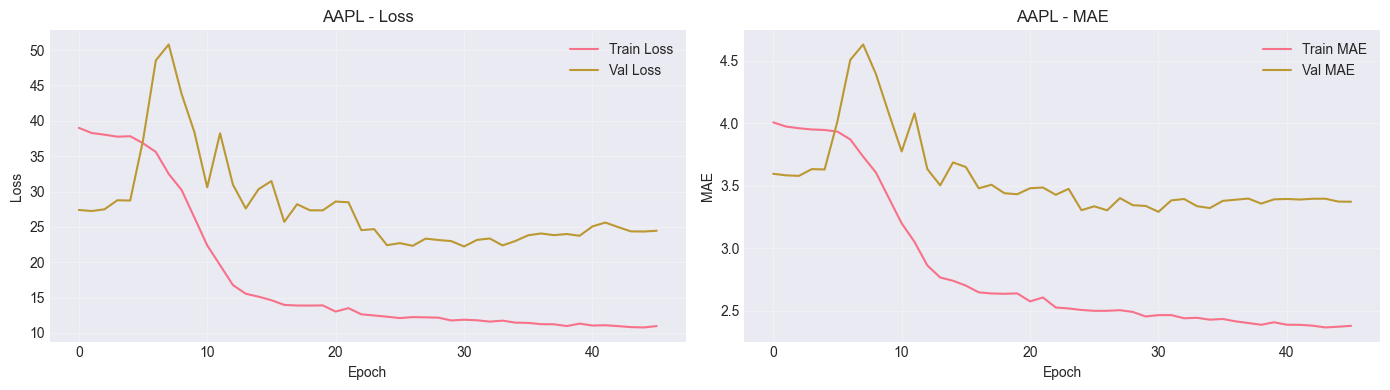


Évaluation pour AAPL

TRAIN:
  1d     | RMSE:  1.7570 | MAE:  1.2205 | R²:  0.0245 | n=2638
  5d     | RMSE:  3.4619 | MAE:  2.6169 | R²:  0.1854 | n=2638
  30d    | RMSE:  4.1464 | MAE:  3.2430 | R²:  0.8220 | n=2638

VAL:
  1d     | RMSE:  1.6837 | MAE:  1.2908 | R²: -0.0063 | n=294
  5d     | RMSE:  3.3617 | MAE:  2.6452 | R²:  0.0545 | n=294
  30d    | RMSE:  7.2490 | MAE:  5.9392 | R²:  0.2137 | n=294

TEST:
  1d     | RMSE:  1.7781 | MAE:  1.3289 | R²: -0.0640 | n=734
  5d     | RMSE:  4.0962 | MAE:  3.2781 | R²: -0.2121 | n=734
  30d    | RMSE: 12.5621 | MAE: 10.3628 | R²: -0.9477 | n=734

ANALYSE MSFT:


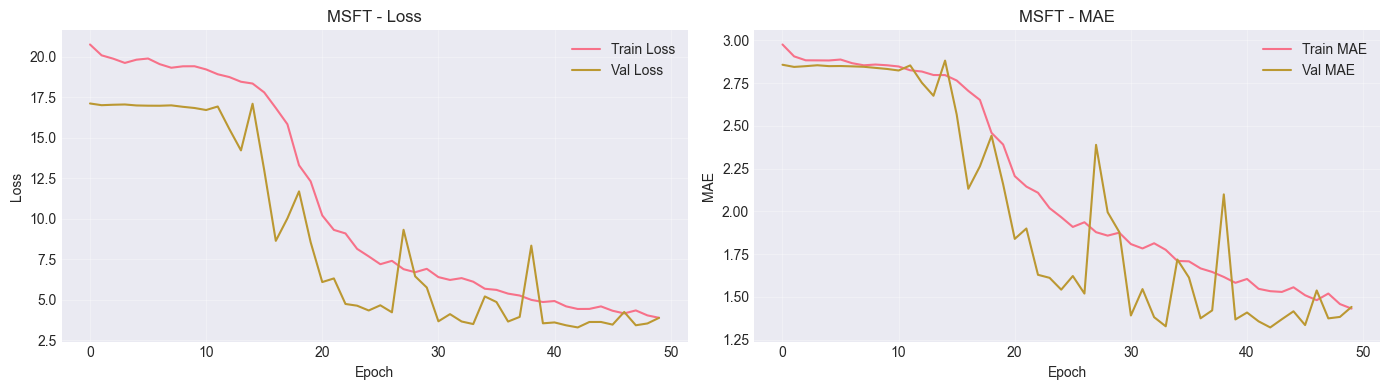


Évaluation pour MSFT

TRAIN:
  1d     | RMSE:  1.5259 | MAE:  1.0465 | R²:  0.1027 | n=2638
  5d     | RMSE:  2.4574 | MAE:  1.8419 | R²:  0.4187 | n=2638
  30d    | RMSE:  1.8886 | MAE:  1.3988 | R²:  0.9256 | n=2638

VAL:
  1d     | RMSE:  1.3479 | MAE:  1.0213 | R²:  0.0506 | n=294
  5d     | RMSE:  2.4516 | MAE:  1.8247 | R²:  0.2793 | n=294
  30d    | RMSE:  1.4434 | MAE:  1.1173 | R²:  0.9489 | n=294

TEST:
  1d     | RMSE:  1.7253 | MAE:  1.3021 | R²:  0.0265 | n=734
  5d     | RMSE:  3.2340 | MAE:  2.4869 | R²:  0.1910 | n=734
  30d    | RMSE:  2.1019 | MAE:  1.5824 | R²:  0.9263 | n=734

ANALYSE GOOGL:


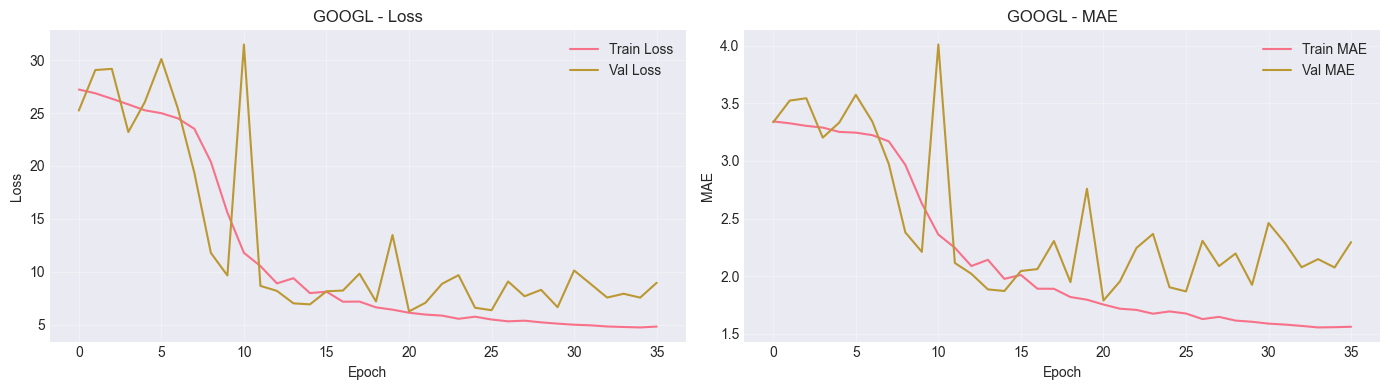


Évaluation pour GOOGL

TRAIN:
  1d     | RMSE:  1.5896 | MAE:  1.0821 | R²:  0.0520 | n=2638
  5d     | RMSE:  3.0406 | MAE:  2.2581 | R²:  0.2551 | n=2638
  30d    | RMSE:  2.0969 | MAE:  1.5587 | R²:  0.9333 | n=2638

VAL:
  1d     | RMSE:  1.5975 | MAE:  1.1563 | R²: -0.0136 | n=294
  5d     | RMSE:  3.2055 | MAE:  2.3938 | R²:  0.0951 | n=294
  30d    | RMSE:  2.4363 | MAE:  1.8177 | R²:  0.8792 | n=294

TEST:
  1d     | RMSE:  2.0732 | MAE:  1.5296 | R²: -0.0295 | n=734
  5d     | RMSE:  4.2527 | MAE:  3.3630 | R²:  0.0550 | n=734
  30d    | RMSE:  4.6387 | MAE:  3.5294 | R²:  0.7202 | n=734

ANALYSE AMZN:


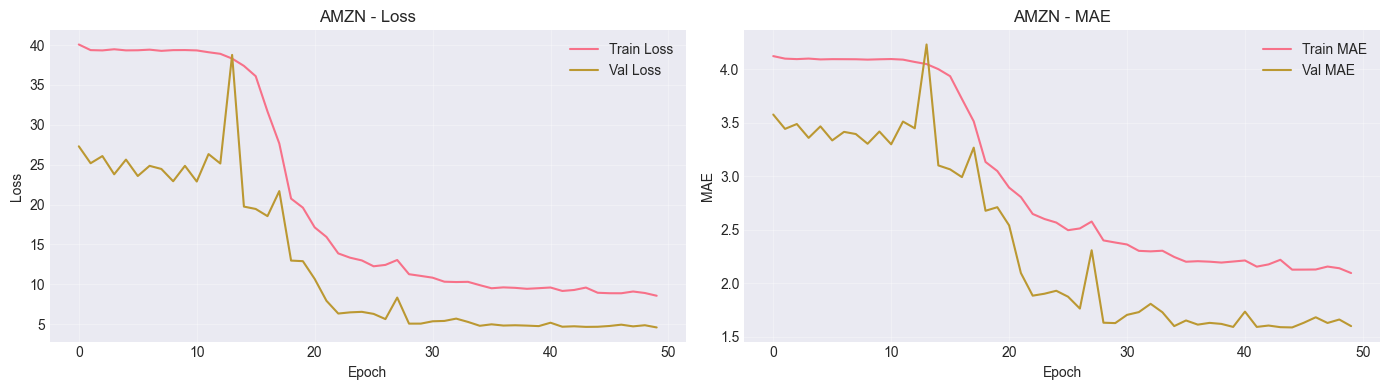


Évaluation pour AMZN

TRAIN:
  1d     | RMSE:  1.9395 | MAE:  1.3478 | R²:  0.0601 | n=2638
  5d     | RMSE:  3.6661 | MAE:  2.7569 | R²:  0.2788 | n=2638
  30d    | RMSE:  2.2810 | MAE:  1.5975 | R²:  0.9453 | n=2638

VAL:
  1d     | RMSE:  1.5856 | MAE:  1.1655 | R²:  0.0363 | n=294
  5d     | RMSE:  3.0613 | MAE:  2.5116 | R²:  0.1736 | n=294
  30d    | RMSE:  1.3833 | MAE:  1.1218 | R²:  0.9581 | n=294

TEST:
  1d     | RMSE:  2.3721 | MAE:  1.7061 | R²:  0.0413 | n=734
  5d     | RMSE:  4.8452 | MAE:  3.6206 | R²:  0.1937 | n=734
  30d    | RMSE:  2.6029 | MAE:  1.8676 | R²:  0.9545 | n=734

ANALYSE TSLA:


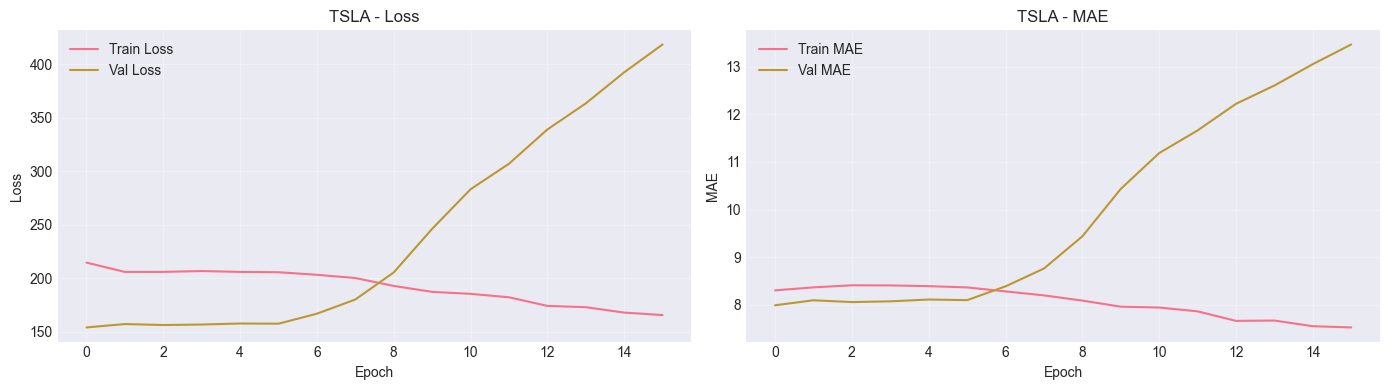


Évaluation pour TSLA

TRAIN:
  1d     | RMSE:  3.5249 | MAE:  2.3882 | R²: -0.0000 | n=2551
  5d     | RMSE:  8.1112 | MAE:  5.8110 | R²: -0.0000 | n=2551
  30d    | RMSE: 23.2422 | MAE: 16.8054 | R²: -0.0018 | n=2551

VAL:
  1d     | RMSE:  3.5560 | MAE:  2.5680 | R²: -0.0008 | n=284
  5d     | RMSE:  7.7672 | MAE:  5.9076 | R²: -0.0035 | n=284
  30d    | RMSE: 19.7327 | MAE: 15.4966 | R²: -0.0266 | n=284

TEST:
  1d     | RMSE:  3.8723 | MAE:  2.8405 | R²: -0.0027 | n=709
  5d     | RMSE:  8.9395 | MAE:  6.9189 | R²: -0.0099 | n=709
  30d    | RMSE: 25.7191 | MAE: 20.6155 | R²: -0.0140 | n=709

GENERATION DES PREDICTIONS FUTURES

PREDICTIONS POUR AAPL
Date: 2025-11-12

Horizon: 1 jour(s) (jusqu'au 2025-11-13)
  Variation prévue: +0.85%
  Variation moyenne: +0.85%
  Score de confiance: 100.0/100
  Intervalle 95%: [+0.84%, +0.85%]
  Volatilité estimée: ±0.00%
  -> STABLE - Variation minime
  -> CONFIANCE ELEVEE - Prédiction fiable

Horizon: 5 jour(s) (jusqu'au 2025-11-17)
  Variation 

In [42]:
# Liste des actions à analyser
tickers_to_train = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Entraînement de tous les modèles LSTM
print("DEBUT DE L'ENTRAINEMENT DES MODELES")
models, histories = train_multiple_models(tickers_to_train, sequences_data, epochs=50, batch_size=32)

print(f"\n{'='*70}")
print("ANALYSE DES PERFORMANCES D'ENTRAINEMENT")
print(f"{'='*70}")

# Pour chaque modèle entraîné, générer les visualisations et l'évaluation
for ticker in tickers_to_train:
    if ticker in models:
        print(f"\nANALYSE {ticker}:")
        # Affiche les courbes d'apprentissage (loss et MAE)
        plot_training_history(histories[ticker], ticker)
        # Évalue le modèle sur les données train/val/test
        evaluate_model(models[ticker], sequences_data, ticker)

print(f"\n{'='*70}")
print("GENERATION DES PREDICTIONS FUTURES")
print(f"{'='*70}")

# Prédire les variations de prix futures pour chaque action
for ticker in tickers_to_train:
    if ticker in models:
        try:
            # Affiche les prédictions formatées avec intervalles de confiance
            print_prediction(ticker, models[ticker], sequences_data, scalers)
        except Exception as e:
            print(f"ERREUR - Impossible de prédire pour {ticker}: {e}")

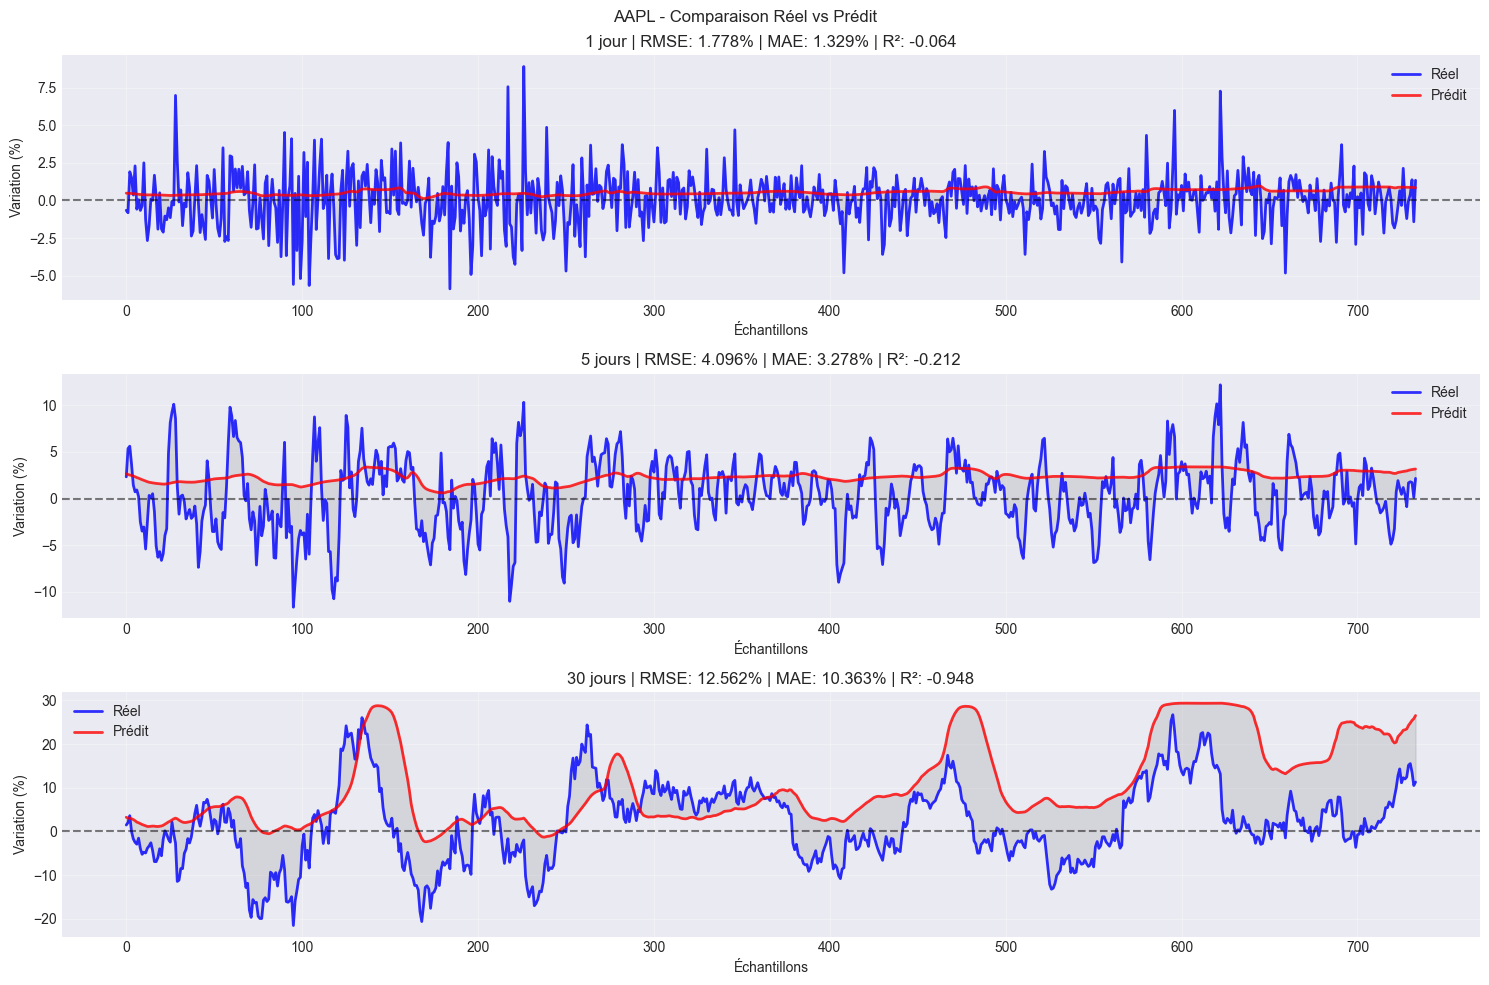

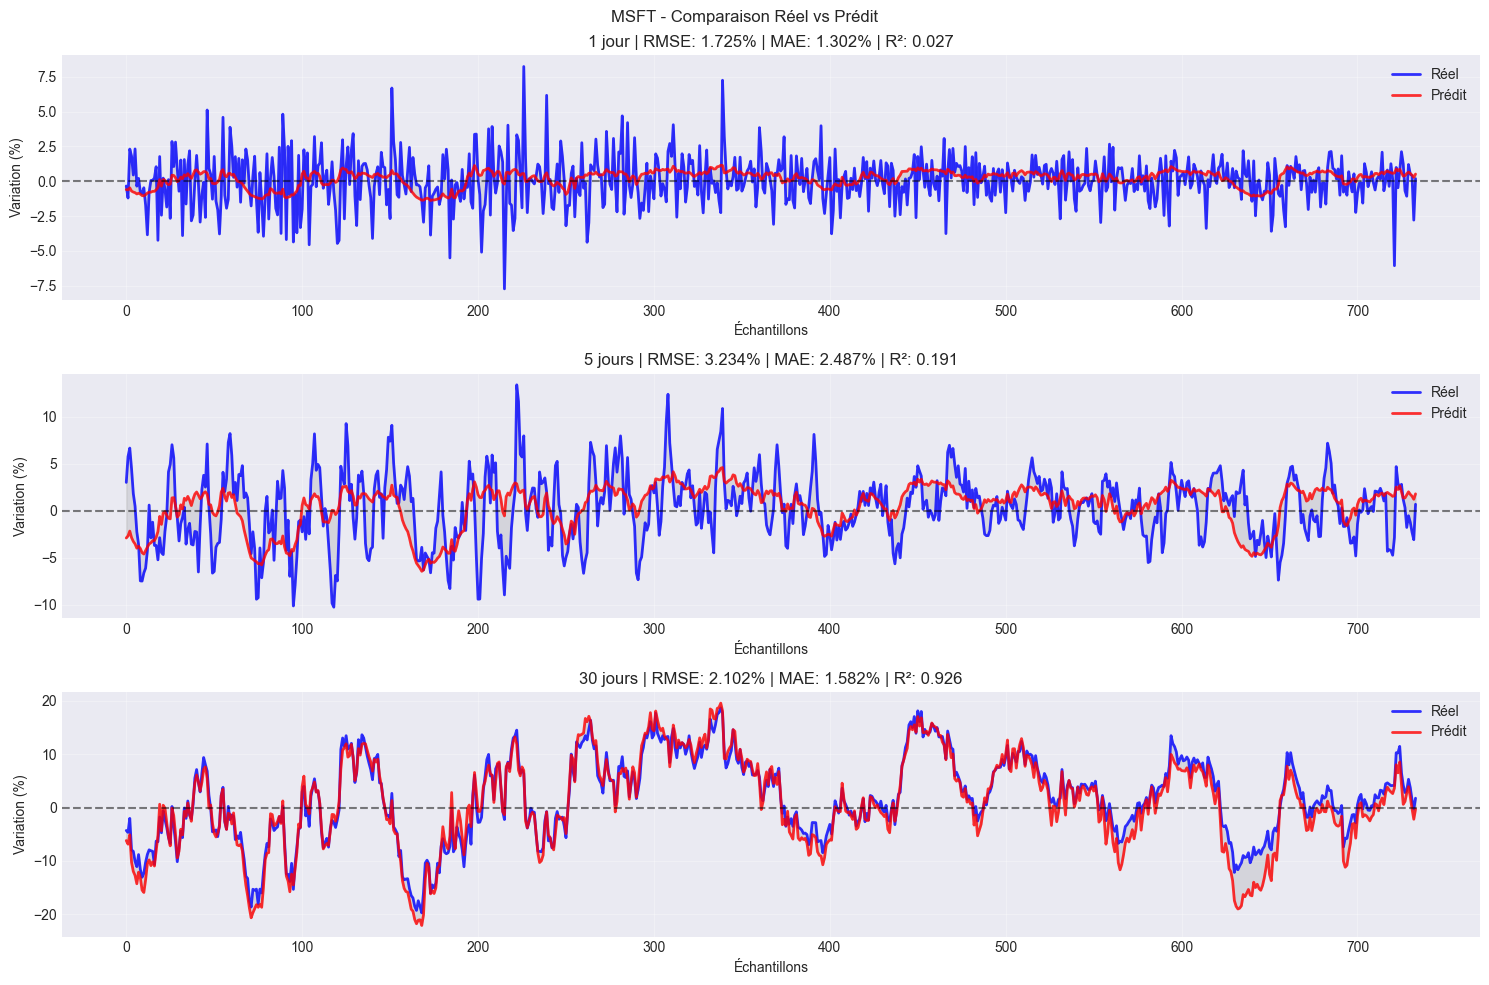

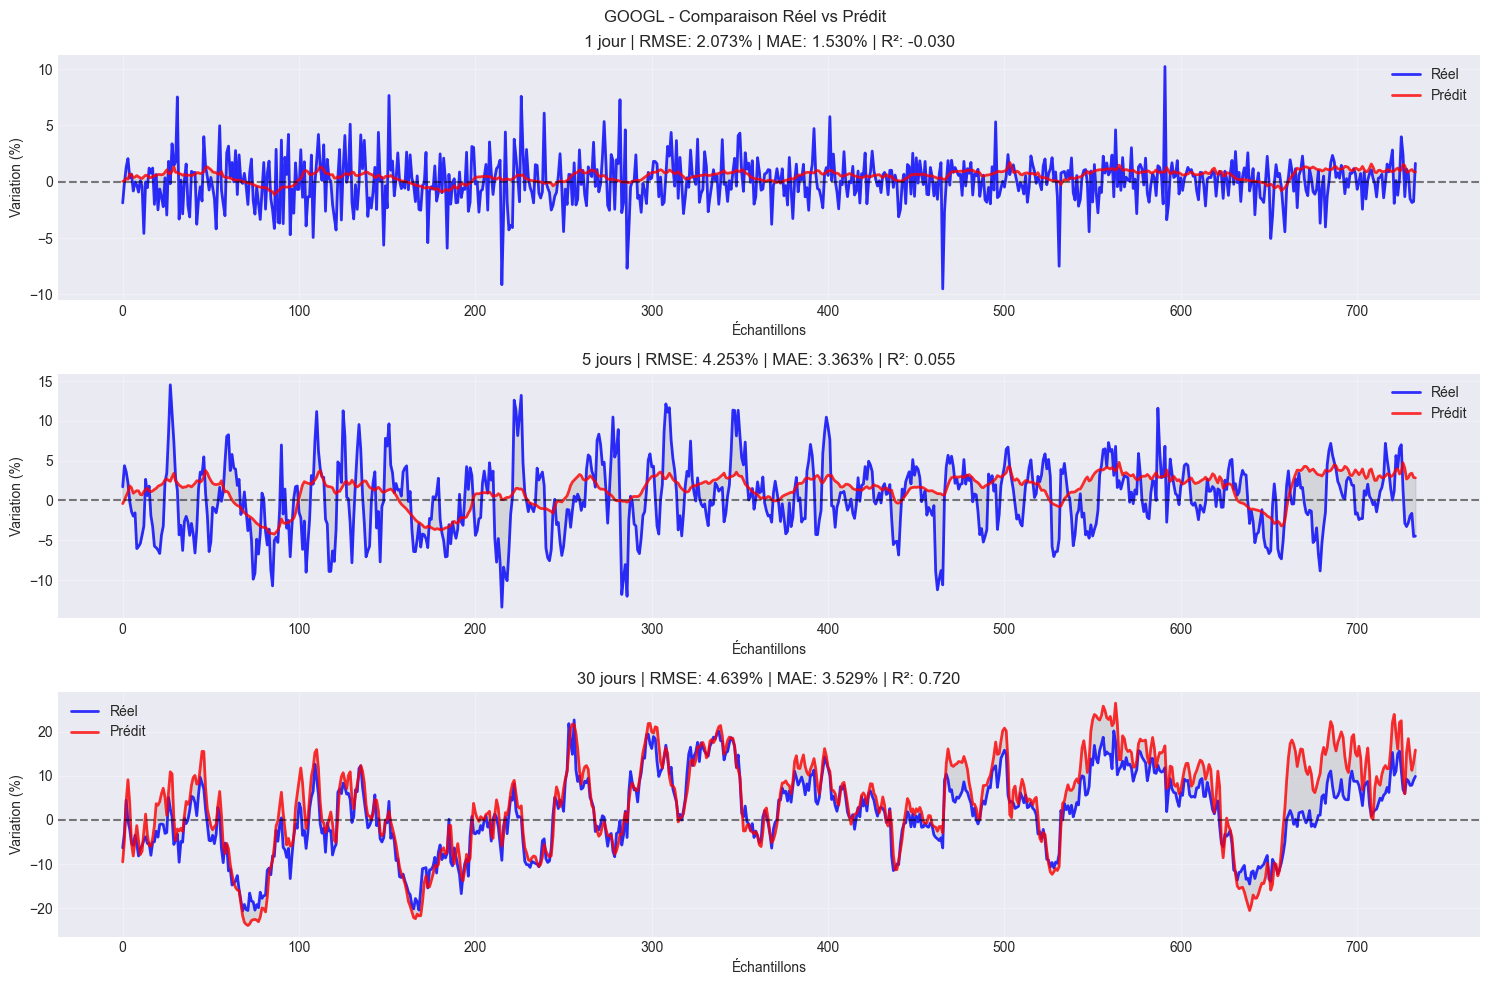

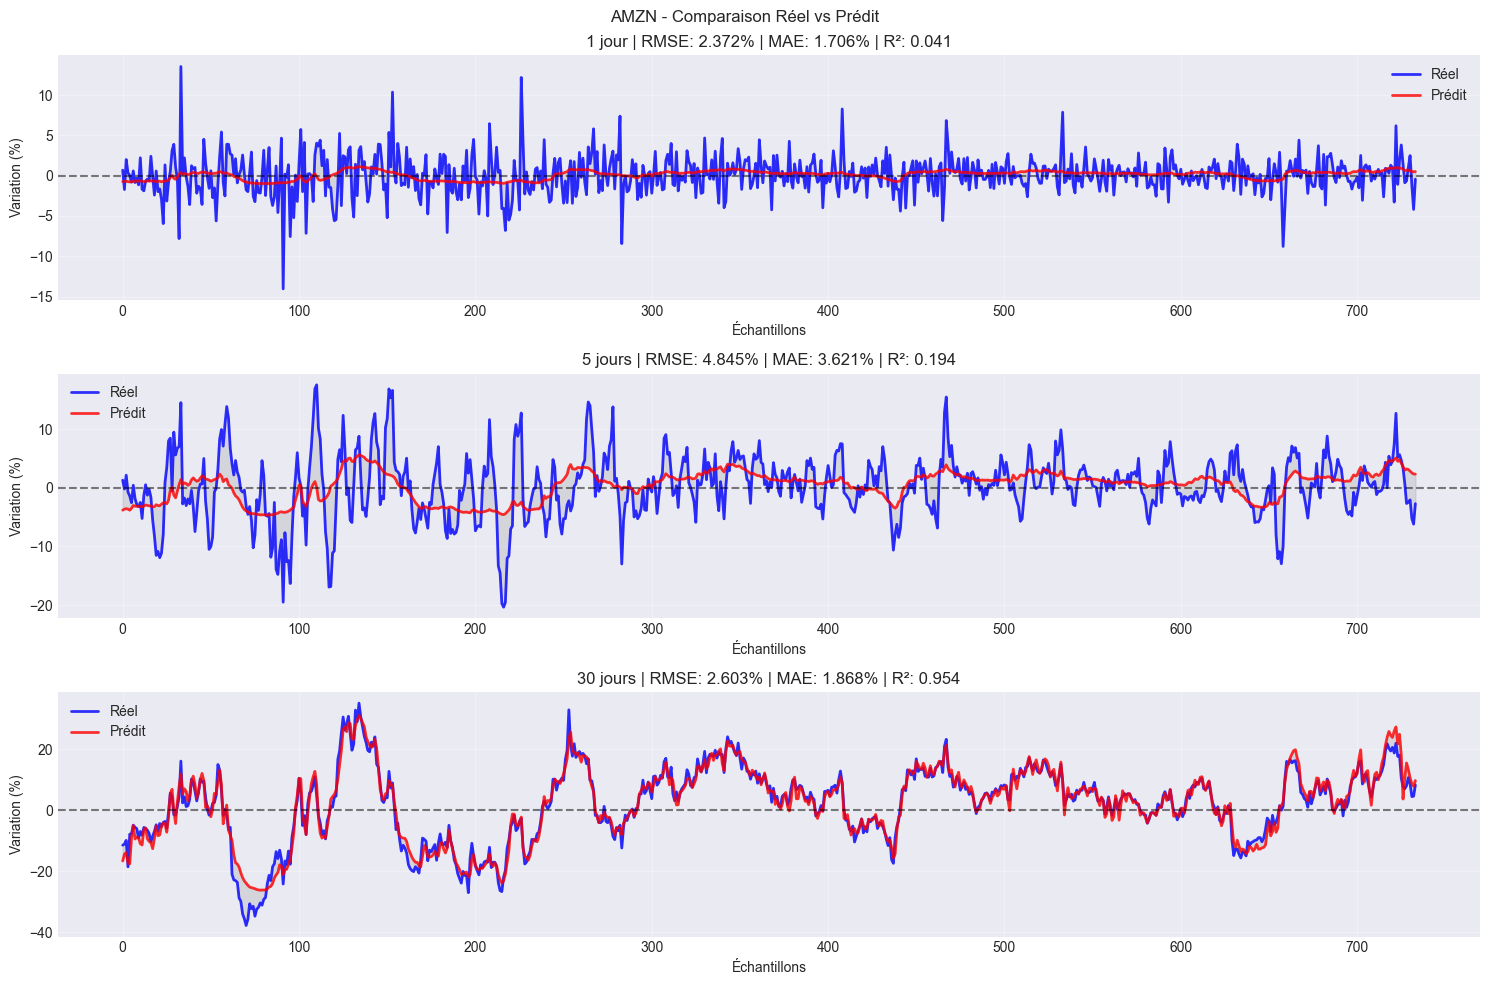

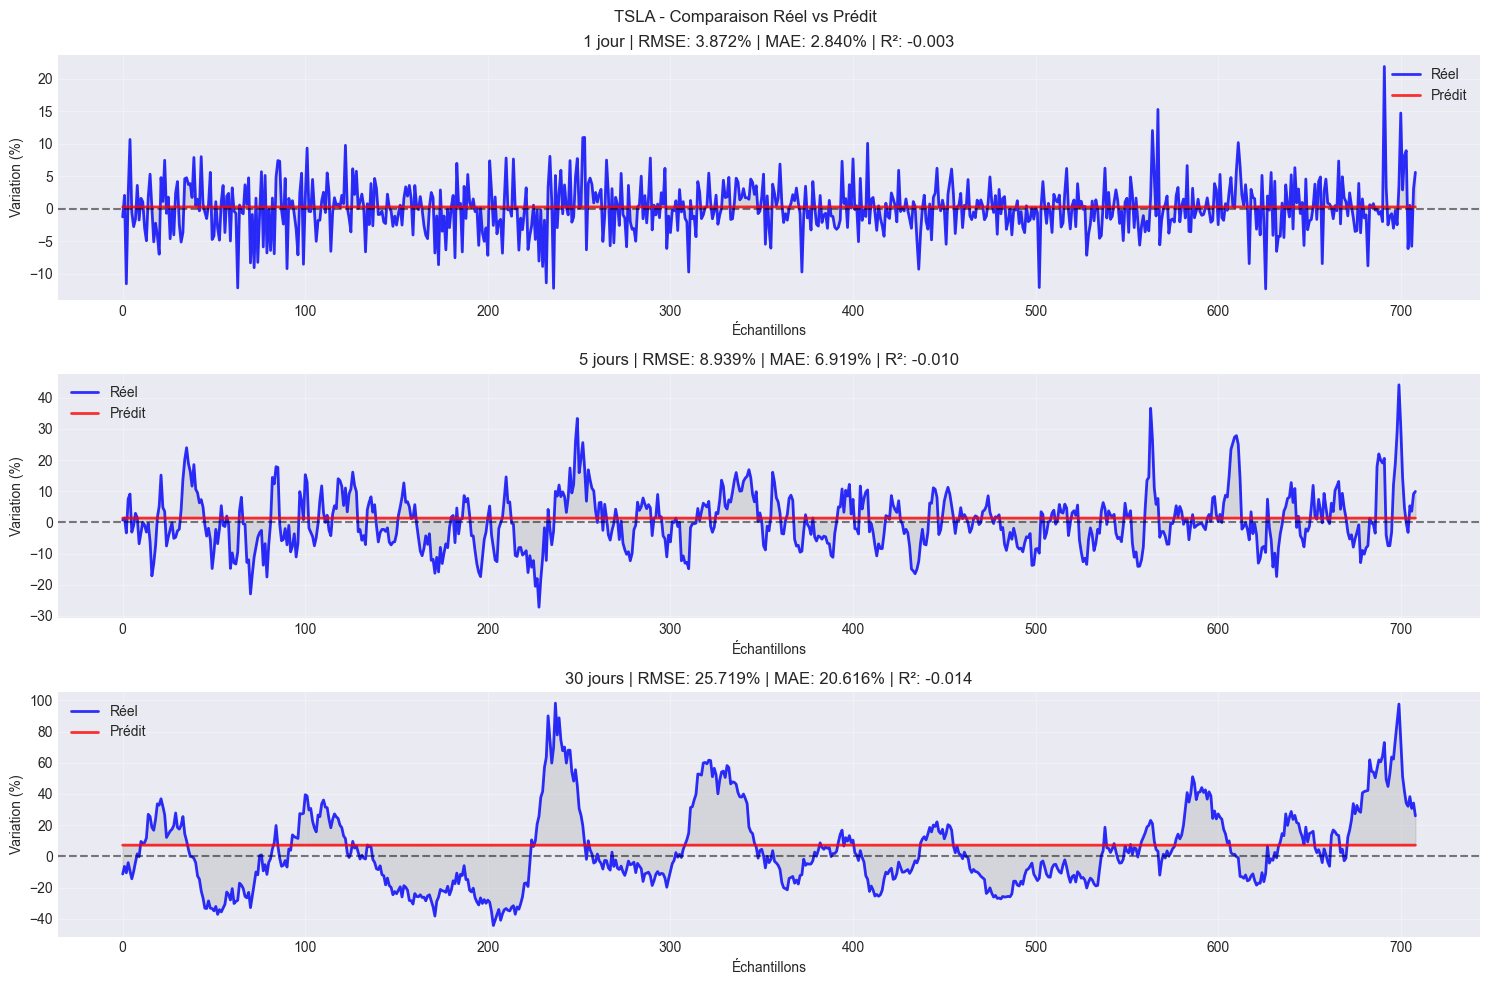

In [ ]:
def plot_backtest_predictions(models, sequences_data, tickers):
    """
    Visualise les prédictions vs valeurs réelles pour évaluer la performance des modèles
    Affiche 3 graphiques par ticker (1 jour, 5 jours, 30 jours)
    """

    for ticker in tickers:
        if ticker not in models:
            continue  # Passe au ticker suivant si modèle non disponible

        # Récupération des données de test
        data = sequences_data[ticker]
        y_true = data['y_test']
        y_pred = models[ticker].predict(data['X_test'], verbose=0)

        # Création des 3 graphiques (un par horizon)
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))

        horizons = ['1 jour', '5 jours', '30 jours']

        for i, (ax, horizon) in enumerate(zip(axes, horizons)):
            actual = y_true[:, i]      # Valeurs réelles
            predicted = y_pred[:, i]   # Valeurs prédites

            # Courbes réel vs prédit
            ax.plot(actual, label='Réel', linewidth=2, color='blue', alpha=0.8)
            ax.plot(predicted, label='Prédit', linewidth=2, color='red', alpha=0.8)
            ax.fill_between(range(len(actual)), actual, predicted, alpha=0.2, color='gray')

            # Calcul des métriques de performance
            rmse = np.sqrt(np.mean((actual - predicted)**2))
            mae = np.mean(np.abs(actual - predicted))
            r2 = 1 - np.sum((actual - predicted)**2) / np.sum((actual - np.mean(actual))**2)

            # Configuration du graphique
            ax.set_title(f'{horizon} | RMSE: {rmse:.3f}% | MAE: {mae:.3f}% | R²: {r2:.3f}')
            ax.set_xlabel('Échantillons')
            ax.set_ylabel('Variation (%)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

        plt.suptitle(f'{ticker} - Comparaison Réel vs Prédit')
        plt.tight_layout()
        plt.show()

# Exécution de la visualisation pour tous les tickers
plot_backtest_predictions(models, sequences_data, tickers_to_train)